In [16]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Model-specific imports
from SBM_SDE import *
from obs_and_flow import *
from training import calc_log_lik

In [17]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

dt_flow = 0.1 #SDE discretization timestep.
t = 300 #Simulation run for T hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
niter = 5000
piter = 250
batch_size = 2 #Number of sets of observation outputs to sample per set of parameters.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.
pretrain_lr = 1e-2
train_lr = 1e-3
batch_size = 1

In [18]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix parameters
c_SOC = 0.5
c_DOC = 0.001
c_MBC = 0.01

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

In [19]:
obs_error_scale = 0.1
x0_SCON = torch.tensor([40, 0.08, 0.8])
x0_prior_SCON = D.multivariate_normal.MultivariateNormal(x0_SCON,
                                                         scale_tril=torch.eye(state_dim_SCON) * obs_error_scale * x0_SCON)

In [20]:
obs_times, obs_means_CON, obs_error_CON = csv_to_obs_df('y_from_x_t_300_dt_0-01.csv', state_dim_SCON, t, obs_error_scale)

In [21]:
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor) #Exogenous DOC input function

In [22]:
obs_model_CON_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt_flow, MU = obs_means_CON, SCALE = obs_error_CON)

In [23]:
def calc_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT):
    #drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], TEMP_TENSOR[:, :-1, :], TEMP_REF, PARAMS_DICT)
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, 1:, :], I_S_TENSOR[:, 1:, :], I_D_TENSOR[:, 1:, :], TEMP_TENSOR[:, :-1, :], TEMP_REF, PARAMS_DICT)
    euler_maruyama_state_sample_object = D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1) # log p(x|x0, theta)
    ll += X0_PRIOR.log_prob(C_PATH[:, 0, :]) # log p(x0|theta)
    
    return ll # (batch_size, )

In [27]:
def train(DEVICE, PRETRAIN_LR, TRAIN_LR, NITER, PRETRAIN_ITER, BATCH_SIZE, OBS_MODEL,
          STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
          DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT,
          LEARN_PARAMS = False, LR_DECAY = 0.1, DECAY_STEP_SIZE = 1000, PRINT_EVERY = 500):
    net = SDEFlow(DEVICE, OBS_MODEL, STATE_DIM, T, DT, N).to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr = PRETRAIN_LR)
    
    if LEARN_PARAMS:
        theta_post = MeanField(PARAMS_DICT)
        theta_prior = D.normal.Normal(torch.zeros_like(theta_post.means),
                                      torch.ones_like(theta_post.std))
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    best_loss_norm = 1e10
    best_loss_ELBO = 1e20
    norm_losses = [] #[best_loss_norm] * 10 
    ELBO_losses = [] #[best_loss_ELBO] * 10
    #C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(), I_D_TENSOR[0, 0, 0].item(), PARAMS_DICT) #Calculate deterministic initial conditions.
    #C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE) #Assign initial conditions to C_PATH.
    
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for it in range(NITER):
            net.train()
            optimizer.zero_grad()
            C_PATH, log_prob = net(BATCH_SIZE) #Obtain paths with solutions at times after t0.
            #C_PATH = torch.cat([C0, C_PATH], 1) #Append deterministic CON initial conditions conditional on parameter values to C path. 
            
            if it < PRETRAIN_ITER:
                l1_norm_element = C_PATH - torch.mean(OBS_MODEL.mu[:3], -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(OBS_MODEL.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #l2_norm.backward()
                #norm_losses.append(l2_norm.item())
                #if len(norm_losses) > 10:
                #    norm_losses.pop(0)
                
                if (it + 1) % PRINT_EVERY == 0:
                    print(f"Moving average norm loss at {it + 1} iterations is: {sum(norm_losses[-10:]) / len(norm_losses[-10:])}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                l1_norm.backward()
                
            else:
                if LEARN_PARAMS:
                    theta_dict, theta, log_q_theta = theta_post()
                    log_p_theta = theta_prior.log_prob(theta).sum(-1)
                else:
                    theta_dict = PARAMS_DICT
                    log_q_theta, log_p_theta = torch.zeros(2)
                    log_lik = calc_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), DT, I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE),
                                       TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, theta_dict)
                
                # - log p(theta) + log q(theta) + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
                ELBO = -log_p_theta.mean() + log_q_theta.mean() - log_lik.mean() - OBS_MODEL(C_PATH, theta_dict) + log_prob.mean()
                best_loss_ELBO = ELBO if ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(ELBO.item())
                #if len(ELBO_losses) > 10:
                #    ELBO_losses.pop(0)
                if (it + 1) % PRINT_EVERY == 0:
                    print(f"Moving average ELBO loss at {it + 1} iterations is: {sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\n C_PATH =', C_PATH)
                    print(theta_dict)
                ELBO.backward()
                
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
            if it == PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] = TRAIN_LR
            elif it % DECAY_STEP_SIZE == 0 and it > PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] *= LR_DECAY
            optimizer.step()
            tq.update()
            
    return net, ELBO_losses

In [ ]:
net, elbo_hist = train(devi, pretrain_lr, train_lr, niter, piter, batch_size, obs_model_CON_noCO2,
                       state_dim_SCON, t, dt_flow, n, t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
                       drift_diffusion_SCON_C, x0_prior_SCON, SCON_C_params_dict,
                       LR_DECAY = 0.1, DECAY_STEP_SIZE = 5000, PRINT_EVERY = 20)

Train Diffusion:   0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
torch.save(net, 'net.pt')

In [41]:
def plot_post(x, obs_model, state_idx=0, num_samples=20,
              ymin=None, ymax=None):
    #net.eval()
    #x, _ = net(num_samples)
    #x0 = x0[(None,) * 2].repeat(num_samples, 1, 1)
    #x = torch.cat((x0, x), 1)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + dt, dt)
    plt.plot(hours, q_mean, label='Posterior mean')
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5,
                     label='Posterior $\\mu \pm 2\sigma$')
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o',
             label='Observed')
    
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel(['SOC', 'DOC', 'MBC'][state_idx])
    plt.ylim((ymin, ymax))
    plt.title('Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {}'.format(num_samples))

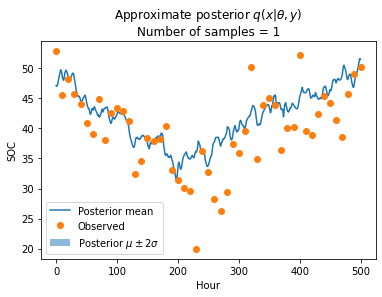

In [42]:
plot_post(x, obs_model_CON_noCO2, 0, num_samples=1)

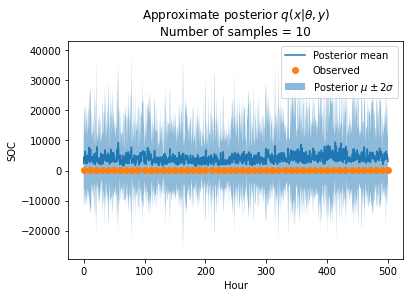

In [45]:
plot_post(x10, obs_model_CON_noCO2, 0, num_samples=10)

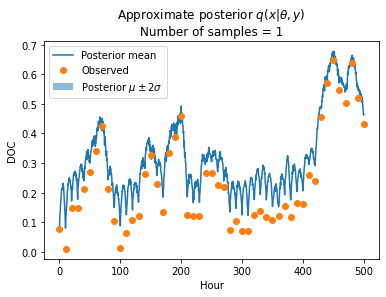

In [46]:
plot_post(x, obs_model_CON_noCO2, 1, num_samples=1)

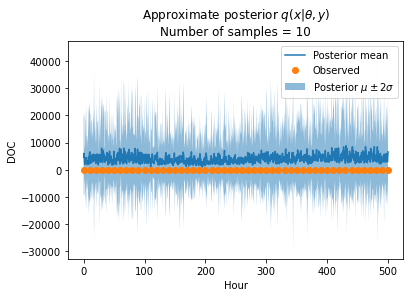

In [47]:
plot_post(x10, obs_model_CON_noCO2, 1, num_samples=10)

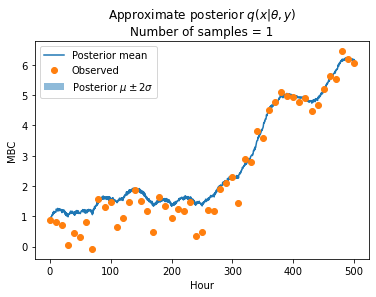

In [48]:
plot_post(x, obs_model_CON_noCO2, 2, num_samples=1)

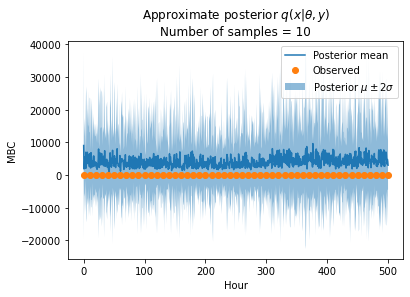

In [49]:
plot_post(x10, obs_model_CON_noCO2, 2, num_samples=10)

In [ ]:
x

In [51]:
def plot_elbo(elbo_hist, xmin=0, ymax=None, yscale='linear', title=None):
    iters = torch.arange(xmin + 1, len(elbo_hist) + 1)
    plt.plot(iters, elbo_hist[xmin:])
    plt.ylim((None, ymax))
    plt.yscale(yscale)
    plt.ylabel('ELBO')
    plt.xlabel('Iteration')
    plt.title(title)

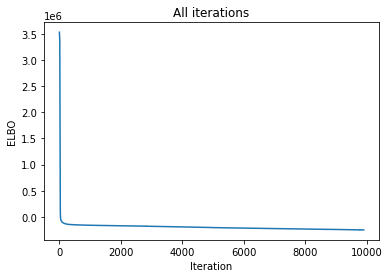

In [52]:
plot_elbo(elbo_hist, title='All iterations')

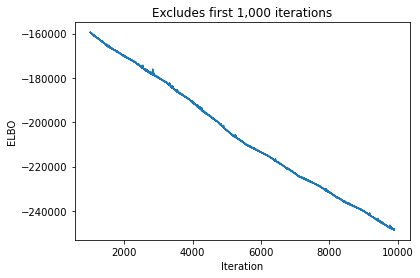

In [54]:
plot_elbo(elbo_hist, xmin=1000, title='Excludes first 1,000 iterations')